In [2]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [3]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

X_train = train_df.drop(["Label", "Attack"], axis=1)
y_train = train_df["Attack"] 

X_eval = eval_df.drop(['Label', 'Attack'], axis=1)
y_eval = eval_df['Attack']

X_test = test_df.drop(['Label', 'Attack'], axis=1)
y_test = test_df['Attack']

In [4]:
# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [25]:
df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/test_df_with_predictions.csv')
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [26]:
relevant_columns = [ 'Label', 'Attack', 
       'Default_RF_All_Features_Predictions',
       'Tuned_RFall_Features_Predictions',
       #'Tuned_RFall_RFECV_Features_Predictions', # not included in plots, as the results are really bad
       'Tuned_RFall_permutation_features_Predictions',
       'Default_RF_selected_Features_Predictions',
       'Tuned_RF_selected_Features_Predictions',

       'Default_XGB_All_Features_Predictions',
       'Tuned_XGBall_Features_Predictions',
       'Tuned_XGBall_RFECV_Features_Predictions',
       'Tuned_XGBall_permutation_Features_Predictions',
       'Default_XGB_selected_Features_Predictions',
       'Tuned_XGB_selected_Features_Predictions'
       ]

df = df[relevant_columns]
df = df.rename(columns={"Default_RF_All_Features_Predictions": "RF_77_features",
                     "Tuned_RFall_Features_Predictions": "RF_tuned_77_features",
                     #"Tuned_RFall_RFECV_Features_Predictions": "RF_tuned_3_features",
                     "Tuned_RFall_permutation_features_Predictions": "RF_tuned_38_features",
                     "Default_RF_selected_Features_Predictions": "RF_14_features",
                     "Tuned_RF_selected_Features_Predictions": "RF_tuned_14_features",

                     "Default_XGB_All_Features_Predictions": "XGB_77_features",
                     "Tuned_XGBall_Features_Predictions": "XGB_tuned_77_features",                  
                     "Tuned_XGBall_RFECV_Features_Predictions": "XGB_tuned_RFECV_46_features",
                     'Tuned_XGBall_permutation_Features_Predictions': 'XGB_tuned_perm_38_features',
                     "Default_XGB_selected_Features_Predictions": "XGB_14_features",
                     "Tuned_XGB_selected_Features_Predictions": "XGB_tuned_14_features"
                      })

### create heatmap for failed predictions

In [27]:
# Define the model columns and filter attacks
model_columns = [col for col in df.columns if col.startswith('RF') or col.startswith('XGB')]
actual_attacks = df[df['Attack'] == 1]

# Further filter to find rows where any model failed to predict the attack
failed_attacks_mask = actual_attacks[model_columns].apply(lambda x: (x == 0).any(), axis=1)
failed_attacks = actual_attacks[failed_attacks_mask]

# Create a binary DataFrame indicating failures (1) and successes (0)
failure_binary_df = failed_attacks[model_columns].applymap(lambda x: 1 if x == 0 else 0)

# Include the 'Label' column in the failure_binary_df for grouping
failure_binary_df['Label'] = failed_attacks['Label']
label_counts = failure_binary_df['Label'].value_counts()
sorted_labels = np.sort(failure_binary_df['Label'].unique())

# Sort the DataFrame by this order
failure_binary_df['Label'] = pd.Categorical(failure_binary_df['Label'], categories=sorted_labels, ordered=True)
sorted_failure_df = failure_binary_df.sort_values(by='Label')

# Separate the label for plotting and remove it from data for heatmap
labels = sorted_failure_df['Label']
sorted_failure_df = sorted_failure_df.drop(columns='Label')

# Transpose for heatmap plotting
sorted_failure_df_transposed = sorted_failure_df.T

/tmp/ipykernel_13624/795201122.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  failure_binary_df = failed_attacks[model_columns].applymap(lambda x: 1 if x == 0 else 0)


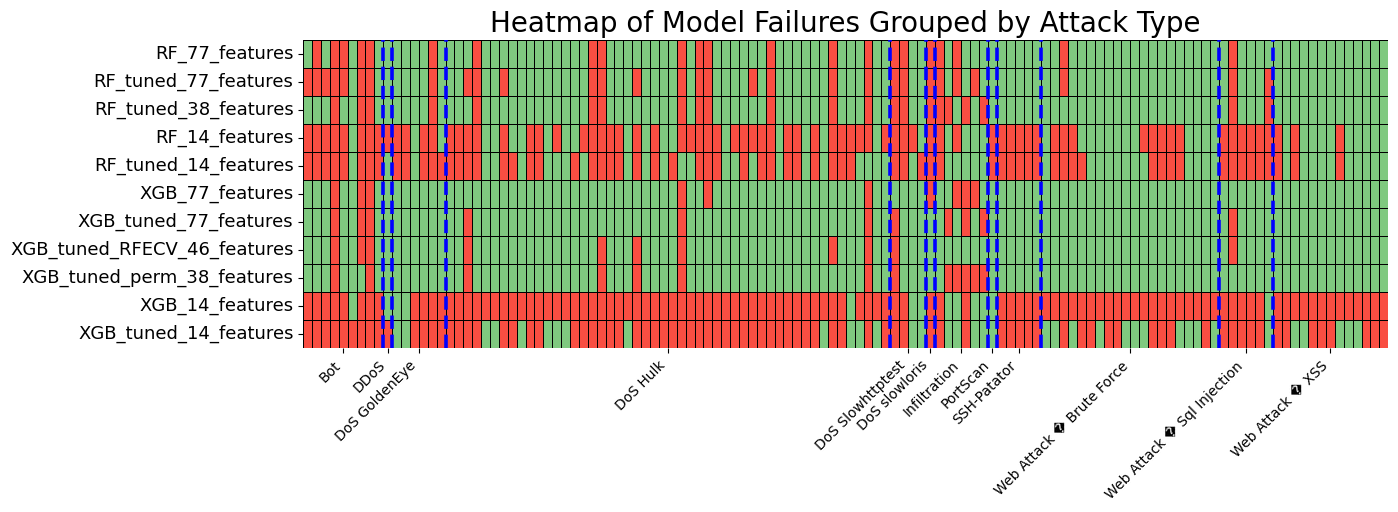

In [28]:
# plot heatmap
plt.figure(figsize=(14, 4))
cmap = mcolors.ListedColormap(['#7fc97f', '#f94e42'])
ax = sns.heatmap(sorted_failure_df_transposed, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')

# Add vertical lines between groups
cumulative_counts = np.cumsum(label_counts[sorted_labels])
for count in cumulative_counts[:-1]:  # Skip the last line
    plt.axvline(x=count, color='blue', linestyle='--', linewidth=2.6)  # Change color and style as needed

# Setup x-ticks for attack types
tick_positions = cumulative_counts - label_counts[sorted_labels] / 2
plt.xticks(tick_positions, sorted_labels, rotation=45, ha='right')
plt.yticks(fontsize = 13)

ax.set_title('Heatmap of Model Failures Grouped by Attack Type', size = 20)
plt.show()

In [29]:
# get columns
model_columns = [col for col in df.columns if col.startswith('RF') or col.startswith('XGB')]

# Create a binary DataFrame where 1 indicates a failure and 0 indicates a success
attack_cases = df[df['Attack'] == 1]

# For each model, mark failure (where prediction is 0) and success (where prediction is 1)
failure_binary_df = attack_cases[model_columns].applymap(lambda x: 1 if x == 0 else 0)
failure_binary_df['Label'] = attack_cases['Label']

# Group by 'Label' and calculate the mean of each group for each model
failure_rates = failure_binary_df.groupby('Label').mean()
failure_rates = failure_rates.T

# multiply by 100 to convert proportions to percentages
#failure_rates *= 100
failure_rates = failure_rates.round(2)
failure_rates


/tmp/ipykernel_13624/3396217045.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  failure_binary_df = attack_cases[model_columns].applymap(lambda x: 1 if x == 0 else 0)


Label,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,FTP-Patator,Heartbleed,Infiltration,PortScan,SSH-Patator,Web Attack � Brute Force,Web Attack � Sql Injection,Web Attack � XSS
RF_77_features,0.19,0.0,0.01,0.00,0.03,0.01,0.0,0.0,0.2,0.00,0.0,0.05,0.17,0.00
RF_tuned_77_features,0.26,0.0,0.01,0.01,0.03,0.01,0.0,0.0,0.3,0.00,0.0,0.05,0.33,0.00
RF_tuned_38_features,0.11,0.0,0.01,0.00,0.03,0.01,0.0,0.0,0.4,0.00,0.0,0.00,0.33,0.00
RF_14_features,0.30,0.0,0.03,0.01,0.04,0.01,0.0,0.0,0.2,0.03,0.1,0.36,1.00,0.23
RF_tuned_14_features,0.30,0.0,0.04,0.01,0.04,0.01,0.0,0.0,0.1,0.03,0.1,0.36,1.00,0.23
XGB_77_features,0.11,0.0,0.00,0.00,0.00,0.01,0.0,0.0,0.3,0.00,0.0,0.00,0.00,0.00
XGB_tuned_77_features,0.11,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.3,0.00,0.0,0.00,0.17,0.00
XGB_tuned_RFECV_46_features,0.11,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.17,0.00
XGB_tuned_perm_38_features,0.07,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.5,0.00,0.0,0.00,0.00,0.00
XGB_14_features,0.30,0.0,0.03,0.02,0.03,0.01,0.0,0.0,0.2,0.00,0.1,0.91,0.83,1.00


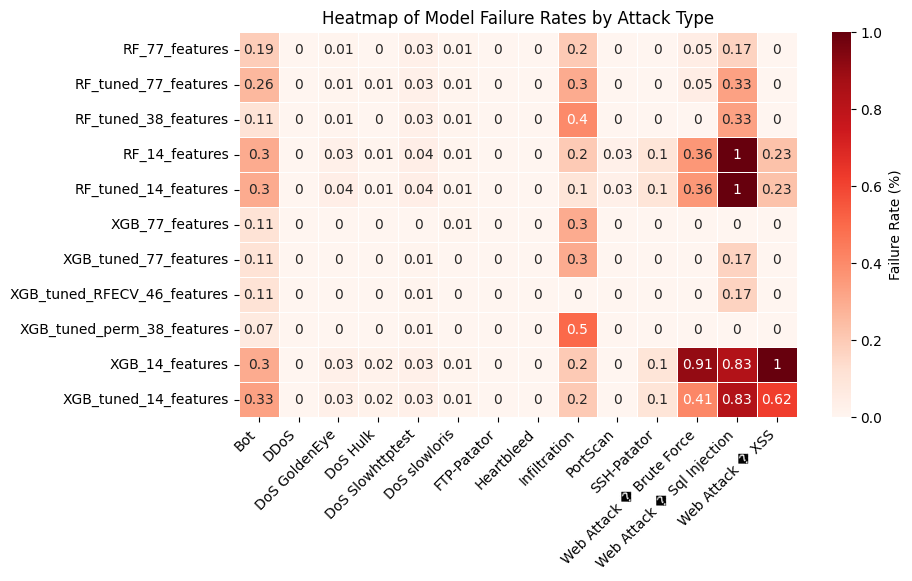

In [30]:
# Create heatmap of proportion of failures
plt.figure(figsize=(9, 5))
ax = sns.heatmap(failure_rates, annot=True, cmap='Reds', linewidths=.5, cbar_kws={'label': 'Failure Rate (%)'})
ax.set_title('Heatmap of Model Failure Rates by Attack Type')
plt.xticks(rotation=45, ha="right")
plt.xlabel('')
plt.show()


In [31]:
# Calculate the counts of each label in the train, eval, and test datasets
train_counts = train_df['Label'].value_counts().rename('Train Count')
train_counts['Attack'] = train_df['Attack'].sum()
train_counts = train_counts.sort_values(ascending=False)

eval_counts = eval_df['Label'].value_counts().rename('Eval Count')
eval_counts['Attack'] = eval_df['Attack'].sum()
eval_counts = eval_counts.sort_values(ascending=False)

test_counts = test_df['Label'].value_counts().rename('Test Count')
test_counts['Attack'] = test_df['Attack'].sum()
test_counts = test_counts.sort_values(ascending=False)

# Combine counts into a single DataFrame
counts_df = pd.DataFrame([train_counts, eval_counts, test_counts]).T
counts_df.fillna(0, inplace=True)  # Replace NaNs with 0 where labels might not appear in one of the dataframes
failure_rates_transposed = failure_rates.T  # Transpose to have labels as rows and models as columns

failed_predictions_count = failure_binary_df.drop(columns='Label').apply(sum, axis=1)  # Sum failures across all models for each instance
failed_predictions_count = failure_binary_df.groupby('Label').apply(lambda df: df.drop(columns='Label').values.sum()).rename('Failed Predictions')

# Calculate the sum of failed predictions for each model within each label
model_failed_counts = failure_binary_df.groupby('Label')[model_columns].sum().add_suffix('_Failures')

# merging
final_stats = pd.concat([counts_df, failure_rates_transposed, model_failed_counts], axis=1)
final_stats


/tmp/ipykernel_13624/3816891624.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_predictions_count = failure_binary_df.groupby('Label').apply(lambda df: df.drop(columns='Label').values.sum()).rename('Failed Predictions')


,Train Count,Eval Count,Test Count,RF_77_features,RF_tuned_77_features,RF_tuned_38_features,RF_14_features,RF_tuned_14_features,XGB_77_features,XGB_tuned_77_features,...,RF_tuned_77_features_Failures,RF_tuned_38_features_Failures,RF_14_features_Failures,RF_tuned_14_features_Failures,XGB_77_features_Failures,XGB_tuned_77_features_Failures,XGB_tuned_RFECV_46_features_Failures,XGB_tuned_perm_38_features_Failures,XGB_14_features_Failures,XGB_tuned_14_features_Failures
Label,,,,,,,,,,,,,,,,,,,,,
Benign,30000,25518,25432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attack,30000,4482,4568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DoS Hulk,14004,2304,2322,0.00,0.01,0.00,0.01,0.01,0.00,0.00,...,13.0,9.0,34.0,28.0,3.0,3.0,6.0,5.0,49.0,39.0
DDoS,10233,1703,1732,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SSH-Patator,1288,34,48,0.00,0.00,0.00,0.10,0.10,0.00,0.00,...,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,5.0,5.0
DoS GoldenEye,839,133,139,0.01,0.01,0.01,0.03,0.04,0.00,0.00,...,1.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,4.0,4.0
PortScan,782,23,30,0.00,0.00,0.00,0.03,0.03,0.00,0.00,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Web Attack � Brute Force,588,23,22,0.05,0.05,0.00,0.36,0.36,0.00,0.00,...,1.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,20.0,9.0
Bot,575,30,27,0.19,0.26,0.11,0.30,0.30,0.11,0.11,...,7.0,3.0,8.0,8.0,3.0,3.0,3.0,2.0,8.0,9.0


In [32]:
final_stats.to_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/count_statistics.csv', index = True)

In [57]:
final_stats = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/output/count_statistics.csv')
final_stats[['Label','Eval Count']]

,Label,Eval Count
0,Benign,25518
1,Attack,4482
2,DoS Hulk,2304
3,DDoS,1703
4,SSH-Patator,34
5,DoS GoldenEye,133
6,PortScan,23
7,Web Attack � Brute Force,23
8,Bot,30
9,FTP-Patator,74
